In [325]:
import handle_data
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

import torch
import numpy as np

import matplotlib.pyplot as plt

In [525]:
variable_to_predict = "NumMissedFlights"

In [564]:
def import_data(desired_features = None):
    # Import the data
    data = handle_data.csv_to_dataframe("logfiles.csv")
    
    include_checkin = True
    include_security = True
    
    data = handle_data.strategies(data, "check_in_strategies.csv", "security_strategies.csv", include_checkin=include_checkin, include_security=include_security, replace=True)
    
    # Feature engineering
    data["Input"]["TotalPassengers"] = data["Input"]['NumberPaxFlight1'] + data["Input"]['NumberPaxFlight2'] + data["Input"]['NumberPaxFlight3'] + data["Input"]['NumberPaxFlight4'] + data["Input"]['NumberPaxFlight5'] + data["Input"]['NumberPaxFlight6'] + data["Input"]['NumberPaxFlight7']
    if include_checkin:
        data["Input"]["TotalCheckinCounters"] = data["Input"]["C7200-6300"] + data["Input"]["C6300-5400"] + data["Input"]["C5400-4500"] + data["Input"]['C4500-3600'] + data["Input"]['C3600-2700']
        data["Input"]["CheckinCountersPerPassenger"] = data["Input"]["TotalCheckinCounters"] / data["Input"]["TotalPassengers"]
    if include_security:
        data["Input"]["TotalSecurityLanes"] = 8 + data["Input"]["S<1800"] + data["Input"]["S1800-3600"] + data["Input"]["S7200-9000"] + data["Input"]['S9000-10800'] + data["Input"]['S>10800']
        data["Input"]["SecurityLanesPerPassenger"] = data["Input"]["TotalSecurityLanes"] / data["Input"]["TotalPassengers"]
    
    
    training, val, test = handle_data.split_data(data)
    
    training = handle_data.manipulate_data(training)
    val = handle_data.manipulate_data(val)
    test = handle_data.manipulate_data(test)
    
    if desired_features != None:
        training["Input"] = training["Input"][desired_features]
        val["Input"] = val["Input"][desired_features]
        test["Input"] = test["Input"][desired_features]
        
    scaler_X = StandardScaler()
    scaler_X.fit(training["Input"])
    
    
    scaler_y = StandardScaler()
    scaler_y.fit(training["Output"][variable_to_predict].to_numpy().reshape(-1, 1))
    
    training_X = scaler_X.transform(training["Input"])
    val_X = scaler_X.transform(val["Input"])
    test_X = scaler_X.transform(test["Input"])
    
    training_y  = scaler_y.transform(training["Output"][variable_to_predict].to_numpy().reshape(-1, 1))
    val_y =  scaler_y.transform(val["Output"][variable_to_predict].to_numpy().reshape(-1, 1))
    test_y = scaler_y.transform(test["Output"][variable_to_predict].to_numpy().reshape(-1, 1))
    
    X_train = torch.tensor(training_X)
    y_train = torch.tensor(training_y)
    
    X_val = torch.tensor(val_X)
    y_val = torch.tensor(val_y)
    
    X_test = torch.tensor(test_X)
    y_test = torch.tensor(test_y)
    
    X_train = X_train.to(torch.float32)
    y_train = y_train.to(torch.float32)
    
    X_val = X_val.to(torch.float32)
    y_val = y_val.to(torch.float32)
    
    X_test = X_test.to(torch.float32)
    y_test = y_test.to(torch.float32)
    
    return scaler_y, X_train, y_train, X_val, y_val, X_test, y_test

In [565]:
# desired_features = ["CallToGateStrategy", "S1800-3600", "NumberPaxFlight7"]
desired_features = None
scaler_y, X_train, y_train, X_val, y_val, X_test, y_test = import_data(desired_features)
n_features = X_train.shape[1]
print(n_features)
print(X_train.shape)
print(y_train.shape)

[DEBUG] Reading logfiles.csv into dataframe
[DEBUG] Finished reading logfiles.csv into dataframe after 0.5300350189208984 seconds
23
torch.Size([76635, 23])
torch.Size([76635, 1])


In [566]:
def create_model(n_neurons):
    model = torch.nn.Sequential(torch.nn.Linear(n_features, n_neurons),
                                torch.nn.Tanh(),
                                torch.nn.Linear(n_neurons, n_neurons),
                                torch.nn.Tanh(),
                                torch.nn.Linear(n_neurons, n_neurons),
                                torch.nn.Tanh(),
                                torch.nn.Linear(n_neurons, n_neurons),
                                torch.nn.Tanh(),
                                torch.nn.Linear(n_neurons, n_neurons),
                                torch.nn.Tanh(),
                                torch.nn.Linear(n_neurons, n_neurons),
                                torch.nn.Tanh(),
                                torch.nn.Linear(n_neurons, n_neurons),
                                torch.nn.Tanh(),
                                torch.nn.Linear(n_neurons, n_neurons),
                                torch.nn.Tanh(),
                                torch.nn.Linear(n_neurons, 1))
    return model

def train_model(model, lr, n_epochs, max_patience, interval):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()
    last_val_loss = np.inf
    patience = 0
    for i in range(1, n_epochs + 1):
        optimizer.zero_grad()
        
        y_pred_train = model(X_train)
        loss = loss_fn(y_train, y_pred_train)
        loss.backward()
        optimizer.step()
        
        
        if i % interval == 0:
            y_pred_val = model(X_val)
            
            loss_val =  loss_fn(y_val, y_pred_val)
            if loss_val > last_val_loss and patience > max_patience:
                break
            elif loss_val > last_val_loss:
                patience += 1
            last_val_loss = loss_val

            print(i, loss_val)
        
    return model

In [567]:
torch.manual_seed(0)
model = create_model(50)
train_model(model, lr=5e-4, n_epochs = 1000, max_patience = 50, interval = 5)

5 tensor(0.2557, grad_fn=<MseLossBackward0>)
10 tensor(0.1910, grad_fn=<MseLossBackward0>)
15 tensor(0.1381, grad_fn=<MseLossBackward0>)
20 tensor(0.1210, grad_fn=<MseLossBackward0>)
25 tensor(0.2292, grad_fn=<MseLossBackward0>)
30 tensor(0.2508, grad_fn=<MseLossBackward0>)
35 tensor(0.1432, grad_fn=<MseLossBackward0>)
40 tensor(0.1096, grad_fn=<MseLossBackward0>)
45 tensor(0.1330, grad_fn=<MseLossBackward0>)
50 tensor(0.1470, grad_fn=<MseLossBackward0>)
55 tensor(0.1103, grad_fn=<MseLossBackward0>)
60 tensor(0.0961, grad_fn=<MseLossBackward0>)
65 tensor(0.0786, grad_fn=<MseLossBackward0>)
70 tensor(0.0654, grad_fn=<MseLossBackward0>)
75 tensor(0.0429, grad_fn=<MseLossBackward0>)
80 tensor(0.0379, grad_fn=<MseLossBackward0>)
85 tensor(0.0331, grad_fn=<MseLossBackward0>)
90 tensor(0.0300, grad_fn=<MseLossBackward0>)
95 tensor(0.0288, grad_fn=<MseLossBackward0>)
100 tensor(0.0305, grad_fn=<MseLossBackward0>)
105 tensor(0.0325, grad_fn=<MseLossBackward0>)
110 tensor(0.0326, grad_fn=<MseLo

Sequential(
  (0): Linear(in_features=23, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): Tanh()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): Tanh()
  (8): Linear(in_features=50, out_features=50, bias=True)
  (9): Tanh()
  (10): Linear(in_features=50, out_features=50, bias=True)
  (11): Tanh()
  (12): Linear(in_features=50, out_features=50, bias=True)
  (13): Tanh()
  (14): Linear(in_features=50, out_features=50, bias=True)
  (15): Tanh()
  (16): Linear(in_features=50, out_features=1, bias=True)
)

In [568]:
#547 
#1435
y_pred_test = model(X_test)

y_pred_test = scaler_y.inverse_transform(y_pred_test.detach().numpy())
y_test_inverse = scaler_y.inverse_transform(y_test.detach().numpy())

rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_test))
mae = mean_absolute_error(y_test_inverse, y_pred_test)
ratio = rmse / mae


print(rmse, mae, ratio)

7.4232244 2.8987715 2.5608175


# Error summary

#### Expenditure:
train_model(model, lr=1e-3, n_epochs = 20000, max_patience = 4, interval = 5)

4 layers of 50 neurons, activation function Tanh, ~180 epochs:
- RMSE = 129.4
- MAE = 102.7
- ratio = 1.26

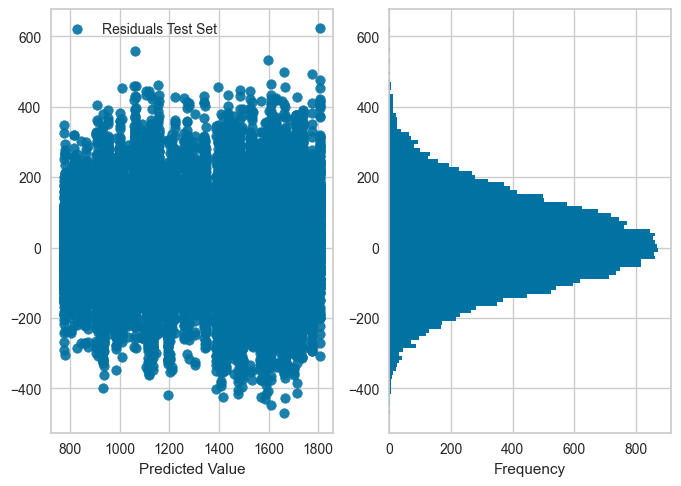

#### AvgTimeToGate:
train_model(model, lr=1e-3, n_epochs = 20000, max_patience = 4, interval = 5).

4 layers of 50 neurons, activation function Tanh, ~225 epochs: 
- RMSE = 82.2
- MAE = 64.2
- ratio = 1.28

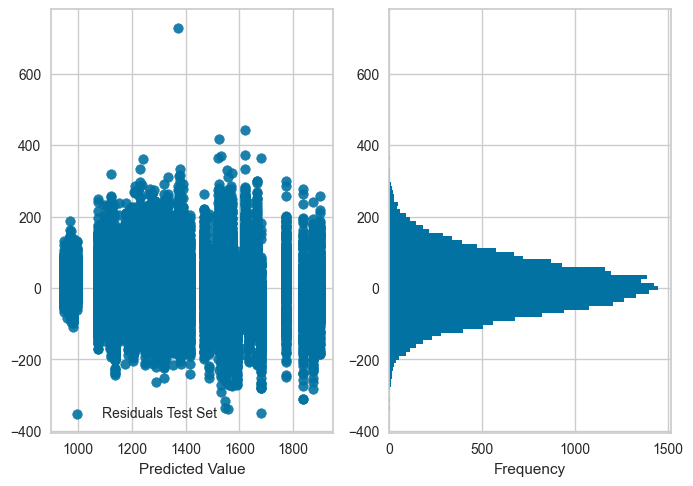

#### NumMissedFlights (for fun):
train_model(model, lr=5e-4, n_epochs = 1000, max_patience = 50, interval = 5)

8 layers of 50 neurons, activation function Tanh, ~620 epochs: 
- RMSE = 7.42
- MAE = 2.90
- ratio = 2.56

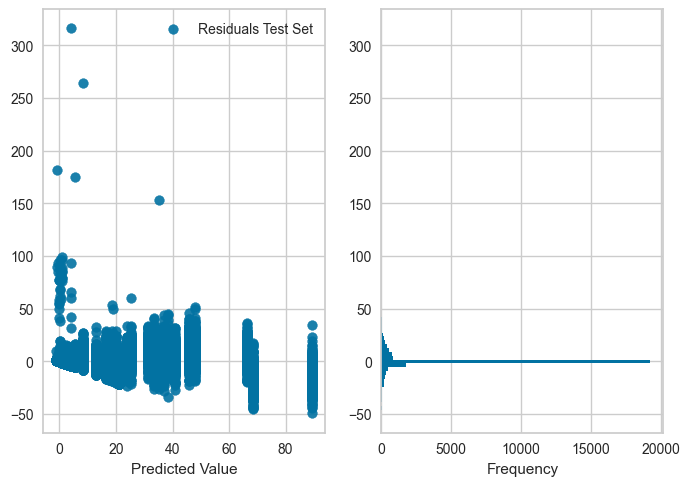

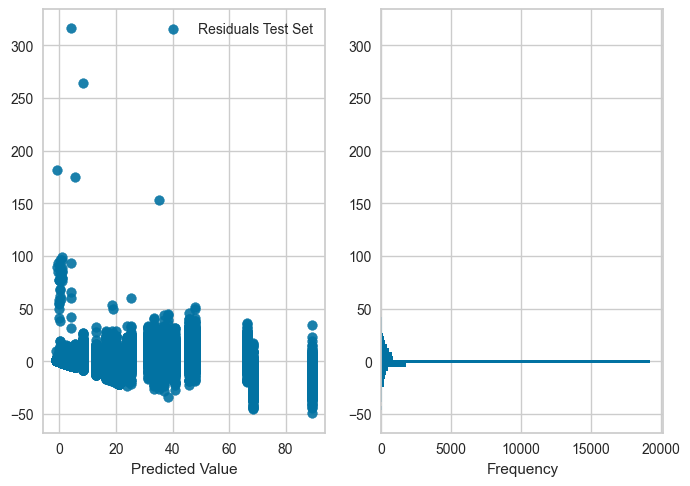

In [569]:
residuals = y_test_inverse - y_pred_test

plt.subplot(121)
plt.scatter(y_pred_test, residuals, alpha = 0.9, label='Residuals Test Set')
plt.xlabel("Predicted Value")
plt.legend()
plt.subplot(122)
plt.hist(residuals, bins=100, orientation=u'horizontal')
plt.xlabel("Frequency")
plt.savefig("Scatter", dpi=400)
x = 1
# plt.ylim(0, 10000)
# plt.xlim(-50, 50)